1. Gerekli kütüphaneler

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

2. Veriyi okuma

In [2]:
#_pca Veriyi oku
train_df = pd.read_csv("../datasets/pca/train_mental_pca.csv")
test_df = pd.read_csv("../datasets/pca/test_mental_pca.csv")

X_train = train_df.drop("treatment", axis=1)
y_train = train_df["treatment"]
X_test = test_df.drop("treatment", axis=1)
y_test = test_df["treatment"]

3. ANN Wrapper

In [3]:
def create_ann_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
ann_model = KerasClassifier(build_fn=create_ann_model, epochs=20, batch_size=32, verbose=0)

4. Diğer modellerin tanımı

In [5]:
svm_model = SVC(probability=True, kernel='linear', random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)

5. Voting Classifier

In [6]:
# Voting Classifier (yalnızca sklearn modelleriyle)
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('lr', lr_model),
        ('knn', knn_model)
    ],
    voting='soft'
)

# Eğit
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(kernel='linear', probability=True,
                                  random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

6. Tahmin

In [7]:
# Tahmin
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

7. Değerlendirme

📋 Sınıflandırma Raporu (Voting Classifier):

              precision    recall  f1-score   support

           0       0.68      0.74      0.71       124
           1       0.72      0.66      0.69       125

    accuracy                           0.70       249
   macro avg       0.70      0.70      0.70       249
weighted avg       0.70      0.70      0.70       249



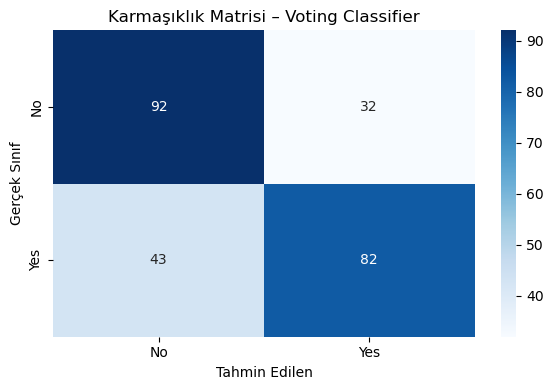

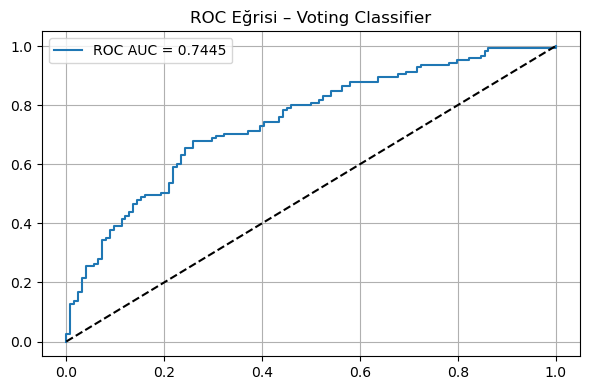

In [8]:
# Rapor
print("📋 Sınıflandırma Raporu (Voting Classifier):\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Karmaşıklık Matrisi – Voting Classifier")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrisi – Voting Classifier")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()